In [1]:
from astrometry.util.fits import *
import pylab as plt
from collections import Counter
from astropy.table import Table
from astrometry.util.starutil_numpy import *
from glob import glob
import os
from astrometry.util.util import *

In [2]:
# This is the copilot database dumped to FITS, via python copilot.py --fits db.fits
T = fits_table('ibis-copilot-db-to-2025-10-20.fits')
len(T)

9367

In [3]:
T.cut(T.mjd_obs > 0)
len(T)

8895

In [5]:
# Dates:
T.mjd_obs.min(), T.mjd_obs.max(), mjdtodate(T.mjd_obs.min()), mjdtodate(T.mjd_obs.max())

(np.float64(60458.79428742),
 np.float64(60969.38551155),
 datetime.datetime(2024, 5, 28, 19, 3, 46, 433077),
 datetime.datetime(2025, 10, 21, 9, 15, 8, 197930))

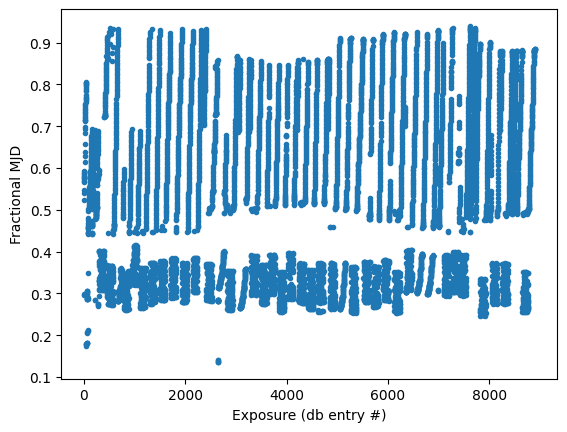

In [6]:
plt.plot(np.fmod(T.mjd_obs - 0.5, 1.0), '.');
plt.xlabel('Exposure (db entry #)')
plt.ylabel('Fractional MJD');

In [7]:
# Cut to medium-band filters
T.cut([f.startswith('M') for f in T.band])
len(T)

5202

In [8]:
Counter(T.obstype)

Counter({np.str_('object'): 3955, np.str_('dome flat'): 1247})

In [9]:
# Cut to normal exposures (not flats)
T.cut(T.obstype == 'object')
len(T)

3955

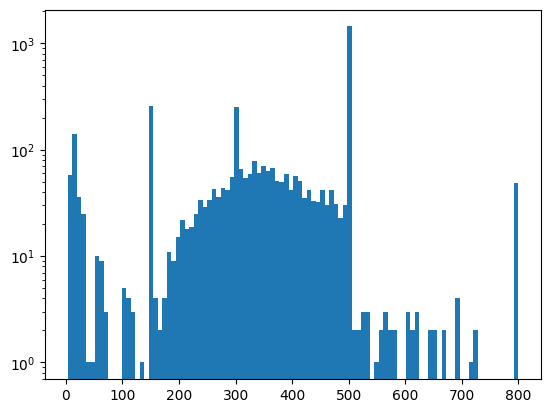

In [10]:
plt.hist(T.exptime, bins=100, log=True);

In [12]:
# Cut various bogus exposures
T.cut(T.exptime >= 100.)
len(T)

3627

In [13]:
# Drop expfactor = 0: failed to calibrate
T.cut(T.expfactor > 0)
T.speed = 1./T.expfactor
len(T)

3627

In [14]:
T.cut(T.seeing < 3.)
len(T)

3608

In [15]:
T.cut(T.transparency < 1.2)
len(T)

3603

In [16]:
# Keep only the first entry for each expnum.
_,I = np.unique(T.expnum, return_index=True)
T.cut(I)
len(T)

3585

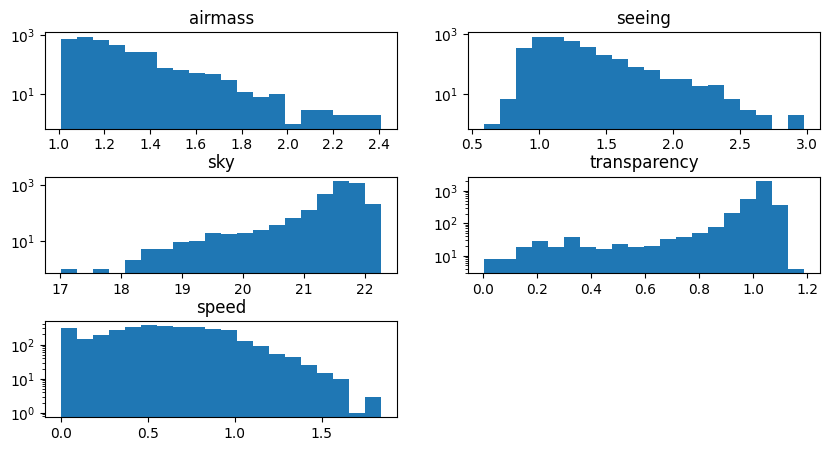

In [17]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(hspace=0.5)
for i,key in enumerate(['airmass', 'seeing', 'sky', 'transparency', 'speed']):
    plt.subplot(3, 2, i+1)
    plt.hist(T.get(key), bins=20, log=True)
    plt.title(key)

In [18]:
Counter(T.band)

Counter({np.str_('M464'): 1293,
         np.str_('M517'): 918,
         np.str_('M490'): 752,
         np.str_('M411'): 356,
         np.str_('M438'): 266})

In [19]:
# RGB Color map
def norm(*c):
    c = np.array(c)
    return np.array([1, 0.8, 1]) * c / np.sum(c)
cc = dict(M411=norm(124/255,0,222/255),
          M438=norm(23/255, 0, 255/255),
          M464=norm(0, 142/255, 255/255),
          M490=norm(0, 255/255, 255/255),
          M517=norm(36/255, 255/255, 0),
         )

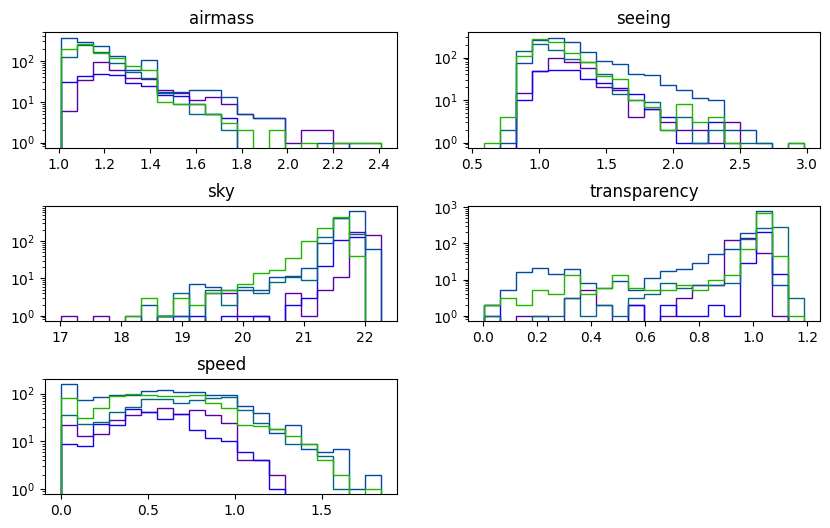

In [20]:
plt.figure(figsize=(10,6))
plt.subplots_adjust(hspace=0.5)

for i,key in enumerate(['airmass', 'seeing', 'sky', 'transparency', 'speed']):
    plt.subplot(3, 2, i+1)
    for b in ['M411', 'M438', 'M464', 'M490', 'M517']:
        I = np.flatnonzero(T.band == b)
        V = T.get(key)
        plt.hist(V[I], bins=20, log=True, range=(V.min(), V.max()), color=cc[b], histtype='step')
    plt.title(key)

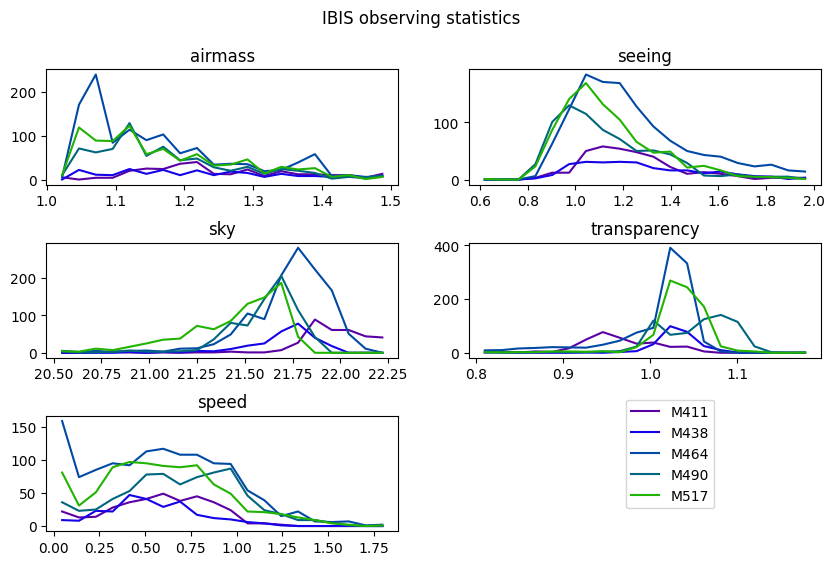

In [21]:
plt.figure(figsize=(10,6))
plt.subplots_adjust(hspace=0.5)
for i,key in enumerate(['airmass', 'seeing', 'sky', 'transparency', 'speed']):
    plt.subplot(3, 2, i+1)
    pp,pl = [],[]
    for b in ['M411', 'M438', 'M464', 'M490', 'M517']:
        I = np.flatnonzero(T.band == b)
        V = T.get(key)
        vmin,vmax = V.min(), V.max()
        if key == 'sky':
            vmin = 20.5
        if key == 'transparency':
            vmin = 0.8
        if key == 'airmass':
            vmax = 1.5
        if key == 'seeing':
            vmax = 2.0
        h,e = np.histogram(V[I], bins=20, range=(vmin, vmax))
        p = plt.plot((e[:-1]+e[1:])/2., h, color=cc[b])
        pp.append(p[0])
        pl.append(b)
    plt.title(key)
plt.figlegend(pp,pl, loc=(0.75,0.1));
plt.suptitle('IBIS observing statistics');
plt.savefig('ibis-stats.png')

In [22]:
np.sum(T.exptime)

np.float32(1.4429139e+06)

In [23]:
np.sum(T.exptime * T.speed), np.sum(T.efftime)

(np.float32(821387.25), np.float32(821387.25))

In [24]:
T.mjd_obsday = np.floor(T.mjd_obs - 0.5).astype(int)

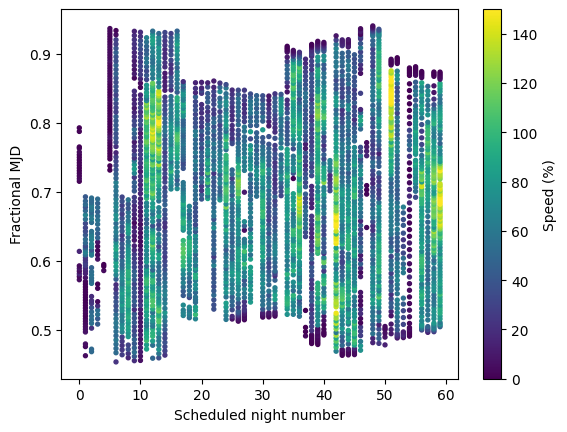

In [25]:
_,day_order = np.unique(T.mjd_obsday, return_inverse=True)
plt.scatter(day_order, np.fmod(T.mjd_obs - 0.5, 1.0), c=T.speed * 100., s=8, vmin=0, vmax=150);
cb = plt.colorbar()
cb.set_label('Speed (%)')
plt.xlabel('Scheduled night number')
plt.ylabel('Fractional MJD');

In [26]:
s = []
for m in T.mjd_obsday:
    d = mjdtodate(m)
    s.append('%i-%02i-%02i' % (d.year, d.month, d.day))
T.mjd_obsday_string = np.array(s)

In [35]:
c = Counter(T.mjd_obsday_string)
#k = list(c.keys())
#k.sort()
#for kk in k:
#    I = np.flatnonzero(T.mjd_obsday_string == kk)
#    print('%s: %i exposures, exptime %.1f hours, range %.2f days' %
#          (kk, c[kk], np.sum(T.exptime[I])/3600., max(T.mjd_obs[I]) - min(T.mjd_obs[I])))

In [36]:
half = 0.5
full = 1.0

scheduled_nights = [
    ('2024-05-30', half),
    ('2024-05-31', half),
    ('2024-06-02', half),
    ('2024-06-03', full),
    ('2024-06-04', half),
    ('2024-06-05', full),
    ('2024-06-06', full),
    ('2024-06-08', full),
    ('2024-06-09', full),
    ('2024-06-29', half),
    ('2024-06-30', half),
    ('2024-07-02', full),
    ('2024-07-03', full),
    ('2024-07-05', full),
    ('2024-07-06', full),
    ('2024-07-08', full),
    ('2024-07-09', full),
    ('2024-07-11', half),
    ('2024-07-12', half),
    ('2024-10-28', full),
    ('2024-10-29', half),
    ('2024-10-30', full),
    ('2024-10-31', half),
    ('2024-11-02', half),
    ('2024-11-03', full),
    ('2024-11-04', half),
    ('2024-11-05', full),
    ('2024-11-23', full),
    ('2024-11-24', full),
    ('2024-11-26', full),
    ('2024-11-27', full),
    ('2024-11-28', half),
    ('2024-11-29', full),
    ('2024-11-30', full),
    ('2024-12-02', full),
    ('2024-12-08', half),
    ('2025-02-28', full),
    ('2025-03-02', full),
    ('2025-03-03', full),
    ('2025-03-26', full),
    ('2025-03-27', full),
    ('2025-03-29', full),
    ('2025-03-30', full),
    ('2025-04-25', full),
    ('2025-04-26', full),
    ('2025-04-28', full),
    ('2025-04-29', full),
    ('2025-05-25', full),
    ('2025-05-26', full),
    ('2025-05-28', full),
    ('2025-05-29', full),
    ('2025-09-22', full),
    ('2025-09-23', full),
    ('2025-09-24', half),
    ('2025-10-14', full),
    ('2025-10-15', half),
    ('2025-10-16', full),
    ('2025-10-17', full),
    ('2025-10-19', full),
    ('2025-10-20', full),
]

In [38]:
k = list(c.keys())
sched = [n for n,_ in scheduled_nights]
k += sched
k.sort()
engineering = []
lost = []
for kk in k:
    I = np.flatnonzero(T.mjd_obsday_string == kk)
    if len(I) == 0:
        print('%s: no exposures found!' % kk)
        lost.append(kk)
        continue
    ss = ''
    if not kk in sched:
        ss = ' (unscheduled)'
        engineering.append(kk)
    print('%s: %i exposures, exptime %.1f hours, range %.2f days%s' %
          (kk, c[kk], np.sum(T.exptime[I])/3600., max(T.mjd_obs[I]) - min(T.mjd_obs[I]), ss))

2024-05-28: 23 exposures, exptime 1.8 hours, range 0.22 days (unscheduled)
2024-05-30: 49 exposures, exptime 4.5 hours, range 0.23 days
2024-05-30: 49 exposures, exptime 4.5 hours, range 0.23 days
2024-05-31: 36 exposures, exptime 3.5 hours, range 0.22 days
2024-05-31: 36 exposures, exptime 3.5 hours, range 0.22 days
2024-06-02: 23 exposures, exptime 3.0 hours, range 0.18 days
2024-06-02: 23 exposures, exptime 3.0 hours, range 0.18 days
2024-06-03: no exposures found!
2024-06-04: 3 exposures, exptime 0.2 hours, range 0.01 days
2024-06-04: 3 exposures, exptime 0.2 hours, range 0.01 days
2024-06-05: 52 exposures, exptime 4.4 hours, range 0.20 days
2024-06-05: 52 exposures, exptime 4.4 hours, range 0.20 days
2024-06-06: 79 exposures, exptime 10.6 hours, range 0.48 days
2024-06-06: 79 exposures, exptime 10.6 hours, range 0.48 days
2024-06-08: no exposures found!
2024-06-09: no exposures found!
2024-06-29: 43 exposures, exptime 5.2 hours, range 0.23 days
2024-06-29: 43 exposures, exptime 5.

In [40]:
# The number of scheduled nights: through 2025-10-20.
# 16 half-nights
# 44 full nights
nights = np.sum([f for _,f in scheduled_nights])
nights

np.float64(52.0)

In [42]:
# Engineering nights
engineering

[np.str_('2024-05-28'), np.str_('2025-04-01'), np.str_('2025-09-08')]

In [44]:
# Omit engineering time
Isched = np.flatnonzero([d not in engineering for d in T.mjd_obsday_string])
total_efftime = np.sum(T.exptime[Isched] * T.speed[Isched])
# total_efftime is equal to just np.sum(T.efftime[Isched])
total_exptime = np.sum(T.exptime[Isched])
total_exptime, total_efftime

(np.float32(1.4310002e+06), np.float32(819539.06))

In [46]:
# EFFTIME per night, in seconds
efftime_per_night = total_efftime / nights
efftime_per_night

np.float64(15760.366586538461)

In [47]:
# EFFTIME per night, in hours
total_efftime / nights / 3600.

np.float64(4.377879607371795)

In [48]:
# EXPTIME per night, in hours
total_exptime / nights / 3600.

np.float64(7.644232104700855)

In [49]:
# The "efftime_per_night" number above is the key result of this analysis.

# Now look at what this implies for the planned IBIS survey.

In [50]:
tiles = Table.read('ibis-tiles.ecsv')
len(tiles)

61390

In [51]:
Counter(tiles['IN_IBIS'])

Counter({np.int16(1): 58120, np.int16(0): 3270})

In [52]:
tiles = tiles[tiles['IN_IBIS'] == 1]
len(tiles)

58120

In [53]:
Iwide = np.flatnonzero(['wide' in o for o in tiles['OBJECT']])
tiles = tiles[Iwide]
len(tiles)

55560

In [64]:
nights_needed = {}
for filt in np.unique(tiles['FILTER']):
    Ifilt = np.flatnonzero(tiles['FILTER'] == filt)
    efft = np.sum(tiles['EFFTIME_GOAL'][Ifilt])
    print('Filter', filt, 'total efftime %.1f hours -> %.1f scheduled nights' % (efft / 3600., efft / efftime_per_night))
    nights_needed[filt] = efft / efftime_per_night

Filter M411 total efftime 1623.4 hours -> 370.8 scheduled nights
Filter M438 total efftime 1314.5 hours -> 300.3 scheduled nights
Filter M464 total efftime 1078.8 hours -> 246.4 scheduled nights
Filter M490 total efftime 1025.4 hours -> 234.2 scheduled nights
Filter M517 total efftime 801.3 hours -> 183.0 scheduled nights


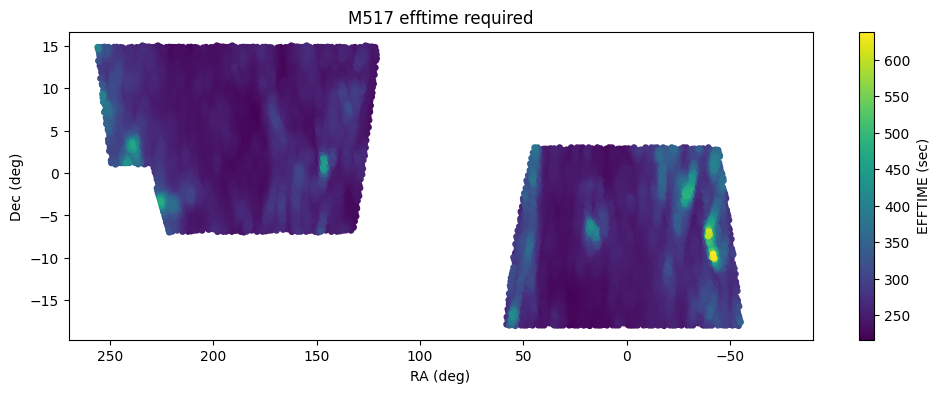

In [65]:
plt.figure(figsize=(12,4))
I = np.flatnonzero(tiles['FILTER'] == 'M517')
I = I[np.argsort(tiles['EFFTIME_GOAL'][I])]
plt.scatter(tiles['RA'][I]
            + -360*(tiles['RA'][I] > 270),
            tiles['DEC'][I], c=tiles['EFFTIME_GOAL'][I], s=15)#, vmin=0);
cb = plt.colorbar()
cb.set_label('EFFTIME (sec)')
plt.title('M517 efftime required')
plt.xlim(270, -90);
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)');

In [87]:
# Count the area covered by the IBIS tiles -- roughly, by looking at the healpix centers
nside = 32
tiles_healpix = np.array([radecdegtohealpix(r,d, nside) for r,d in zip(tiles['RA'], tiles['DEC'])])

In [67]:
sqdeg_sky = 4 * np.pi * np.rad2deg(1.)**2

In [97]:
# Area in sq deg per healpix
sqdeg_hp = sqdeg_sky / (12 * nside**2)

In [98]:
ibis_sqdeg = len(np.unique(tiles_healpix)) * sqdeg_hp
ibis_sqdeg

np.float64(5126.405584949807)

In [89]:
# How many nights needed for the full area with the three reddest filters?
nights_red = sum([nights_needed[f] for f in ['M464', 'M490', 'M517']])
nights_red

np.float64(663.6790104193478)

In [90]:
# Note: the calculations below assume we just randomly select a fraction of the full area, as opposed to,
# say, taking the easiest area.

In [91]:
# How many square degrees in the three reddest filters can we finish with 353 nights?
353 / nights_red * ibis_sqdeg

np.float64(2726.651201977695)

In [92]:
# How many nights would it take us to do 3000 sq deg in three filters?
3000 * nights_red / ibis_sqdeg

np.float64(388.3885108707289)

In [93]:
# How many nights would it take us to do 4200 sq deg in three filters?
4200 * nights_red / ibis_sqdeg

np.float64(543.7439152190204)

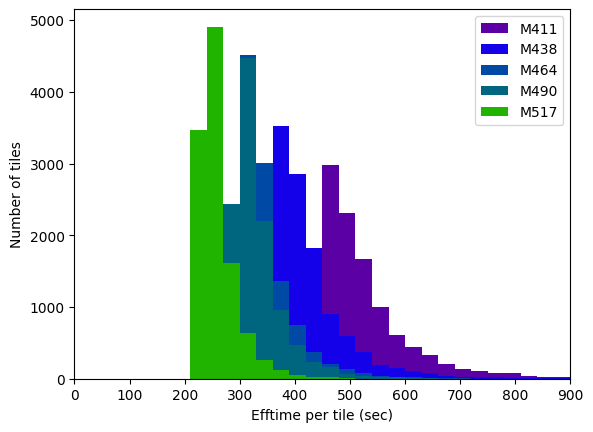

In [94]:
for filt in np.unique(tiles['FILTER']):
    Ifilt = np.flatnonzero(tiles['FILTER'] == filt)
    efft = tiles['EFFTIME_GOAL'][Ifilt]
    plt.hist(efft, color=cc[filt], range=(0,900), bins=30, label=filt)#, histtype='step')
plt.xlim(0,900)
plt.legend()
plt.xlabel('Efftime per tile (sec)')
plt.ylabel('Number of tiles');

In [100]:
# Map from tile RA,Dec to total efftime in the 3 reddest filters
radec_to_efftime = {}
radec_to_healpix = {}
for r,d,b,t,h in zip(tiles['RA'], tiles['DEC'], tiles['FILTER'], tiles['EFFTIME_GOAL'], tiles_healpix):
    if not b in ['M464', 'M490', 'M517']:
        continue
    k = (r,d)
    t0 = radec_to_efftime.get(k, 0.)
    radec_to_efftime[k] = t0 + t
    radec_to_healpix[k] = h

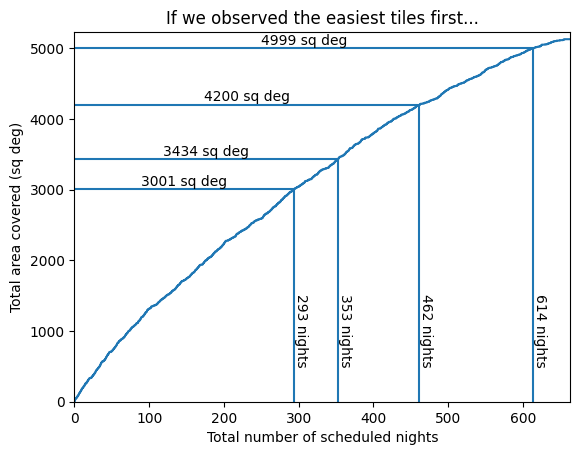

In [150]:
radecs = list(radec_to_efftime.keys())
efftimes = np.array([radec_to_efftime[k] for k in radecs])
hps = np.array([radec_to_healpix[k] for k in radecs])
I = np.argsort(efftimes)
healpixes = set()

total_efftime = []
total_hps = []
got_3k = False
got_42k = False

for i in I:
    healpixes.add(hps[i])
    total_hps.append(len(healpixes))
    total_efftime.append(efftimes[i])

    if not got_3k and len(healpixes) * sqdeg_hp > 3000.:
        i_3k = i
        got_3k = True
    if not got_42k and len(healpixes) * sqdeg_hp > 4200.:
        i_42k = i
        got_42k = True

total_efftime = np.array(total_efftime)
total_efftime = np.cumsum(total_efftime)
total_hps = np.array(total_hps)

total_area = total_hps * sqdeg_hp
total_nights = total_efftime / efftime_per_night

I3000 = np.argmin(np.abs(total_area - 3000))
I353 = np.argmin(np.abs(total_nights - 353))
I4200 = np.argmin(np.abs(total_area - 4200))
I5000 = np.argmin(np.abs(total_area - 5000))

plt.plot(total_nights, total_area, '-')

for i in [I3000, I4200, I353, I5000]:
    plt.hlines(total_area[i], 0, total_nights[i])
    plt.vlines(total_nights[i], 0, total_area[i])

    plt.text(0.5 * total_nights[i], total_area[i]+50, '%i sq deg' % np.round(total_area[i]), ha='center')
    plt.text(total_nights[i], 1000, '%i nights' % np.round(total_nights[i]), ha='left', va='center', rotation=270)


#plt.text(0.5 * total_nights[I353], total_area[I353]+50, '%i sq deg' % floor(total_area[I353]), ha='center')
plt.xlabel('Total number of scheduled nights')
plt.ylabel('Total area covered (sq deg)');
plt.axis([0, total_nights[-1], 0, total_area[-1]+100]);
plt.title('If we observed the easiest tiles first...');

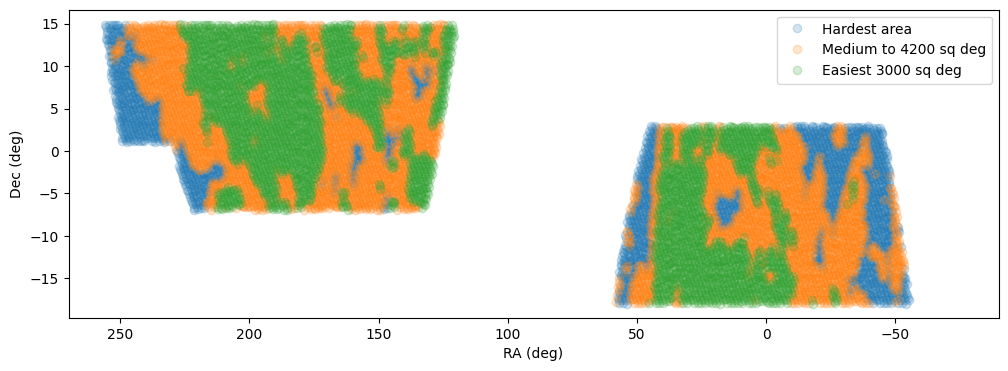

In [145]:
# The analysis above is too optimistic - leaves huges holes in the footprint, doesn't cover all area to full depth, etc
# Also ignores the location of the HSC footprint!
rd = np.array(radecs)
ra = rd[:,0]
ra = ra - 360*(ra > 270)
dec = rd[:,1]
plt.figure(figsize=(12,4))
plt.plot(ra[I[i_42k:]], dec[I[i_42k:]], '.', ms=12, alpha=0.2, label='Hardest area')
plt.plot(ra[I[i_3k:i_42k]], dec[I[i_3k:i_42k]], '.', ms=12, alpha=0.2, label='Medium to 4200 sq deg');
plt.plot(ra[I[:i_3k]], dec[I[:i_3k]], '.', ms=12, alpha=0.2, label='Easiest 3000 sq deg');
plt.xlim(270, -90);
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.legend();